# Task A — EDA & Data Quality

Describe findings and visuals here.

In [ ]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')
DATA_DIR = Path('../dataset')
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])
po = po.merge(deliv, on='order_id', how='left')
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


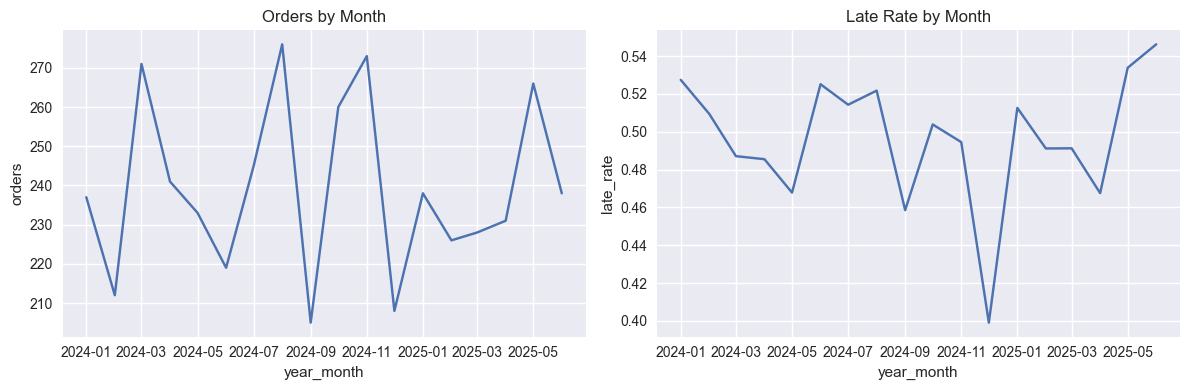

In [ ]:

po['year_month'] = po['order_date'].dt.to_period('M').dt.to_timestamp()
late = po.query('cancelled == 0').assign(late_delivery=lambda d: d['late_delivery'].fillna(0).astype(int))
monthly = late.groupby('year_month').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index()
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(data=monthly, x='year_month', y='orders', ax=ax[0]); ax[0].set_title('Orders by Month')
sns.lineplot(data=monthly, x='year_month', y='late_rate', ax=ax[1]); ax[1].set_title('Late Rate by Month')
plt.tight_layout(); plt.show()
